In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm

num_cores=5
num_simulations = 1000 # number of monte carlo simulations
varscale=1

In [2]:
## each client actually generates data not from true beta, but from 
## true beta+some error; so if they run only sgd alone, they would never converge to the true beta.

np.set_printoptions(precision=4, suppress=True)



In [3]:
# --------------------------
# DFL Settings:
eta = 0.3
alpha = 0.75
#tau = 5
d=2


# Brownian motion

In [4]:
def simulate_Br(d, num_Simulations):
    """
    Simulate Z_t ~ N(0, (K V_K)^{-1}) and compute max ||sum_{s=1}^t Z_s||_2.
    Avoids explicit matrix inversion using Cholesky decomposition.
    
    Args:
        V_K: (d x d) positive definite matrix
        K: Scaling factor (K > 0)
        n: Number of time steps
        num_simulations: Number of independent runs
        
    Returns:
        max_norms: Array of maximum norms (num_simulations,)
    """
    
    
    Z = np.random.multivariate_normal(mean=np.zeros(d), cov= np.eye(d), size=num_simulations)

    # Compute cumulative sums 

    norms = np.linalg.norm(Z, ord=2,  axis=1)

    
    return norms


Br_results= simulate_Br(d, num_simulations)
x_grid = np.linspace(0, 50, 1000)  # Adjust the number of points as needed

prob_Br = np.array([np.mean(Br_results <= x) for x in x_grid])

# Run DFL Local SGD

In [5]:
def A_js(j,s, eta, alpha):
    
    if j==s:
        return 1
    else :
        x=1
        for k in range(j+1, s+1):
            x=x*(1 - eta* (k**(-alpha)) )
    
    return x

In [6]:


def run_DFL(T, K, d, eta, alpha, tau, beta_0, sigma, weights, C, client_error):
    """
    Runs T iterations of decentralized gradient updates.

    Parameters:
      T         : int, total number of iterations.
      K         : int, number of clients/nodes.
      d         : int, dimensionality of the parameter vector.
      eta       : float, step-size constant.
      alpha     : float, exponent controlling step decay over iterations.
      tau       : int, frequency of communication (consensus) steps.
      beta_true : np.array, the true underlying d-dimensional parameter.
      sigma     : np.array, noise standard deviations for each client (length K).
      weights   : np.array, weights for each client (typically equal to 1/K).
      C         : np.array, K x K communication matrix.
      client_error: error vector in true beta for each client.

    Returns:
      theta_traj : list of np.arrays, each an (K x d) array of client parameters at each iteration.
      error_traj : list of floats, each the L2 norm error between the over-client mean parameter estimate and beta_true.
    """
    # Initialize: theta_traj holds the initial parameters and later updates.
    #Y_traj = [np.zeros(d)]
    #error_norm_traj = []
    #error_traj = []
    
    theta=np.zeros((K, d))
    
    
    for t in range(T):
        # Use the most recent parameter matrix; .copy() is important to avoid unintended aliasing.
        #theta = theta_traj[-1].copy()

        # Local gradient descent update for each client
        for k in range(K):
            # Generate single sample for client k
            X_k = np.random.normal(loc=0.0, scale=1.0, size=(1, d))
            y_k = X_k @ (beta_true+client_error[k]) + sigma[k] * np.random.randn(1)
            
            # Compute the gradient at node k.
            # We reshape theta[k] and y_k to ensure proper dimensions.
            residual = X_k @ theta[k].reshape(-1, 1) - y_k.reshape(-1, 1)
            grad_k =  K * weights[k] * (X_k.T @ residual).flatten()
            
            # Update the parameter at client k
            theta[k] = theta[k] - eta * ((t+1) ** (-alpha)) * grad_k

        # Communication (consensus) step every tau iterations.
        if t % tau == 0:
            theta = C @ theta
        
        
    # Compute error.
    error= (T**0.5)* Sigma_inv_sqrt@ (np.mean(theta, axis=0) - beta_0)
    error_norm = np.linalg.norm(error, ord=2)

    return error_norm
    


In [7]:
## run DFL; B=total number of runs to -----------

from joblib import Parallel, delayed
from tqdm import tqdm
from tqdm_joblib import tqdm_joblib

def safe_run_simulation(T,K, sigma, weights, C, client_error, beta_0, seed):
    np.random.seed(seed)
    try:
        error_norm = run_DFL(T, K, d, eta, alpha, tau, beta_0, sigma, weights, C, client_error)
        return  error_norm
    except Exception as e:
        print(f"Error for seed = {seed}: {e}")
        return None


seeds = range(num_simulations)

T= 300
K_list = [20, 40, 60, 80, 100]
tau_list = [10, 20, 30]
results_tau=[]

for tau in tau_list:

    results = []
    for K in tqdm(K_list, desc="K", ncols=100, position=0):

        #K = np.floor(T ** 0.5).astype(int)             # number of decentralized nodes
        tau=5
        d = 2             # dimension of the parameter vector

        np.random.seed(1907) # your favorite seed
        client_error = np.random.normal(loc=0.0, scale=varscale, size=(K,2)) ## errors for clients. client_error= np.zeros(K) if error for each client = 0.
        #client_error = np.zeros(K)

        beta_true = np.array([2.0, -3.0])
        sigma = np.array([random.randint(1, 10) for _ in range(K)])
        weights =  np.ones(K)/K
        beta_0 = np.sum(weights[:, np.newaxis] * (beta_true + client_error), axis=0)

        C = np.zeros((K, K))
        for i in range(K):
            C[i, i] = 1/3                    # self weight
            C[i, (i-1) % K] = 1/3             # left neighbor (with wrap-around)
            C[i, (i+1) % K] = 1/3             # right neighbor


        errors = client_error

        norms_sq = np.sum(errors**2, axis=1)

        sum_diag = np.sum(weights**2 * (sigma**2 + norms_sq))

        sum_outer = np.einsum('ki,kj->ij', errors, (weights**2)[:, None] * errors)

        V_K = sum_diag * np.eye(d) + sum_outer #calculate V_K
        #print(V_K)
        A = np.eye(d) # hessian

        Q = []
        for s in range(1, T + 1):
            eta_js_sum = sum(A_js(s, j, eta=eta, alpha=alpha) for j in range(s, T + 1))
            Q_s = eta* (s**(-alpha)) * eta_js_sum * np.eye(d)
            Q.append(Q_s)

        Sigma_T = np.zeros_like(V_K)
        for Q_s in Q:
            Sigma_T += Q_s  @ V_K  @  Q_s.T 
        Sigma_T /= T
        eigenvalues, Q = np.linalg.eigh(Sigma_T)  # Use eigh for symmetric matrices
        Lambda_inv_sqrt = np.diag(1.0 / np.sqrt(eigenvalues))
        Sigma_inv_sqrt = Q @ Lambda_inv_sqrt @ Q.T
        #print(Sigma_inv_sqrt)

        with tqdm_joblib(tqdm(desc="Running simulations", total=num_simulations, ncols=10)):
            results.append(Parallel(n_jobs=num_cores)(delayed(safe_run_simulation)(T,K, sigma, weights, C, client_error, beta_0, seed) for seed in seeds))
            
    BS_DFL = []        
    for res in results:
        prob_DFL=np.array([np.mean(res <= x) for x in x_grid])
        BS_DFL.append(np.max(np.abs(prob_DFL-prob_Br)))
    results_tau.append(np.array(BS_DFL))
    
    

/Users/sohambonnerjee/jupyter_env/lib/python3.11/site-packages/tqdm_joblib/__init__.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
K:   0%|                                                                      | 0/5 [00:00<?, ?it/s]
Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:  20%|████████████▍                                                 | 1/5 [00:23<01:33, 23.26s/it]

Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:  40%|████████████████████████▊                                     | 2/5 [01:06<01:44, 34.92s/it]


Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:  60%|█████████████████████████████████████▏                        | 3/5 [02:14<01:40, 50.17s/it]



Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
K:  80%|█████████████████████████████████████████████████▌            | 4/5 [03:43<01:05, 65.30s/it]


Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:   0%|                                                                      | 0/5 [00:00<?, ?it/s]




Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
K:  20%|████████████▍                                                 | 1/5 [00:22<01:30, 22.66s/it]


Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:  40%|████████████████████████▊                                     | 2/5 [01:06<01:45, 35.20s/it]





Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
K:  60%|█████████████████████████████████████▏                        | 3/5 [02:10<01:36, 48.46s/it]


Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:  80%|█████████████████████████████████████████████████▌            | 4/5 [03:37<01:03, 63.55s/it]






Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:   0%|                                                                      | 0/5 [00:00<?, ?it/s]







Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
Running si
K:  20%|████████████▍                                                 | 1/5 [00:39<02:38, 39.63s/it]


Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:  40%|████████████████████████▊                                     | 2/5 [01:53<02:59, 59.98s/it]






Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K:  60%|█████████████████████████████████████▏                        | 3/5 [03:28<02:31, 75.75s/it]








Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

Running si
Running si
K:  80%|█████████████████████████████████████████████████▌            | 4/5 [04:56<01:20, 80.50s/it]


Running si

  0%|          | 0/1000 [00:00<?, ?it/s]

K: 100%|██████████████████████████████████████████████████████████████| 5/5 [07:59<00:00, 95.86s/it]


# Plotting

Running si
Running si
Running si
Running si
Running si
Running si
Running si
Running si


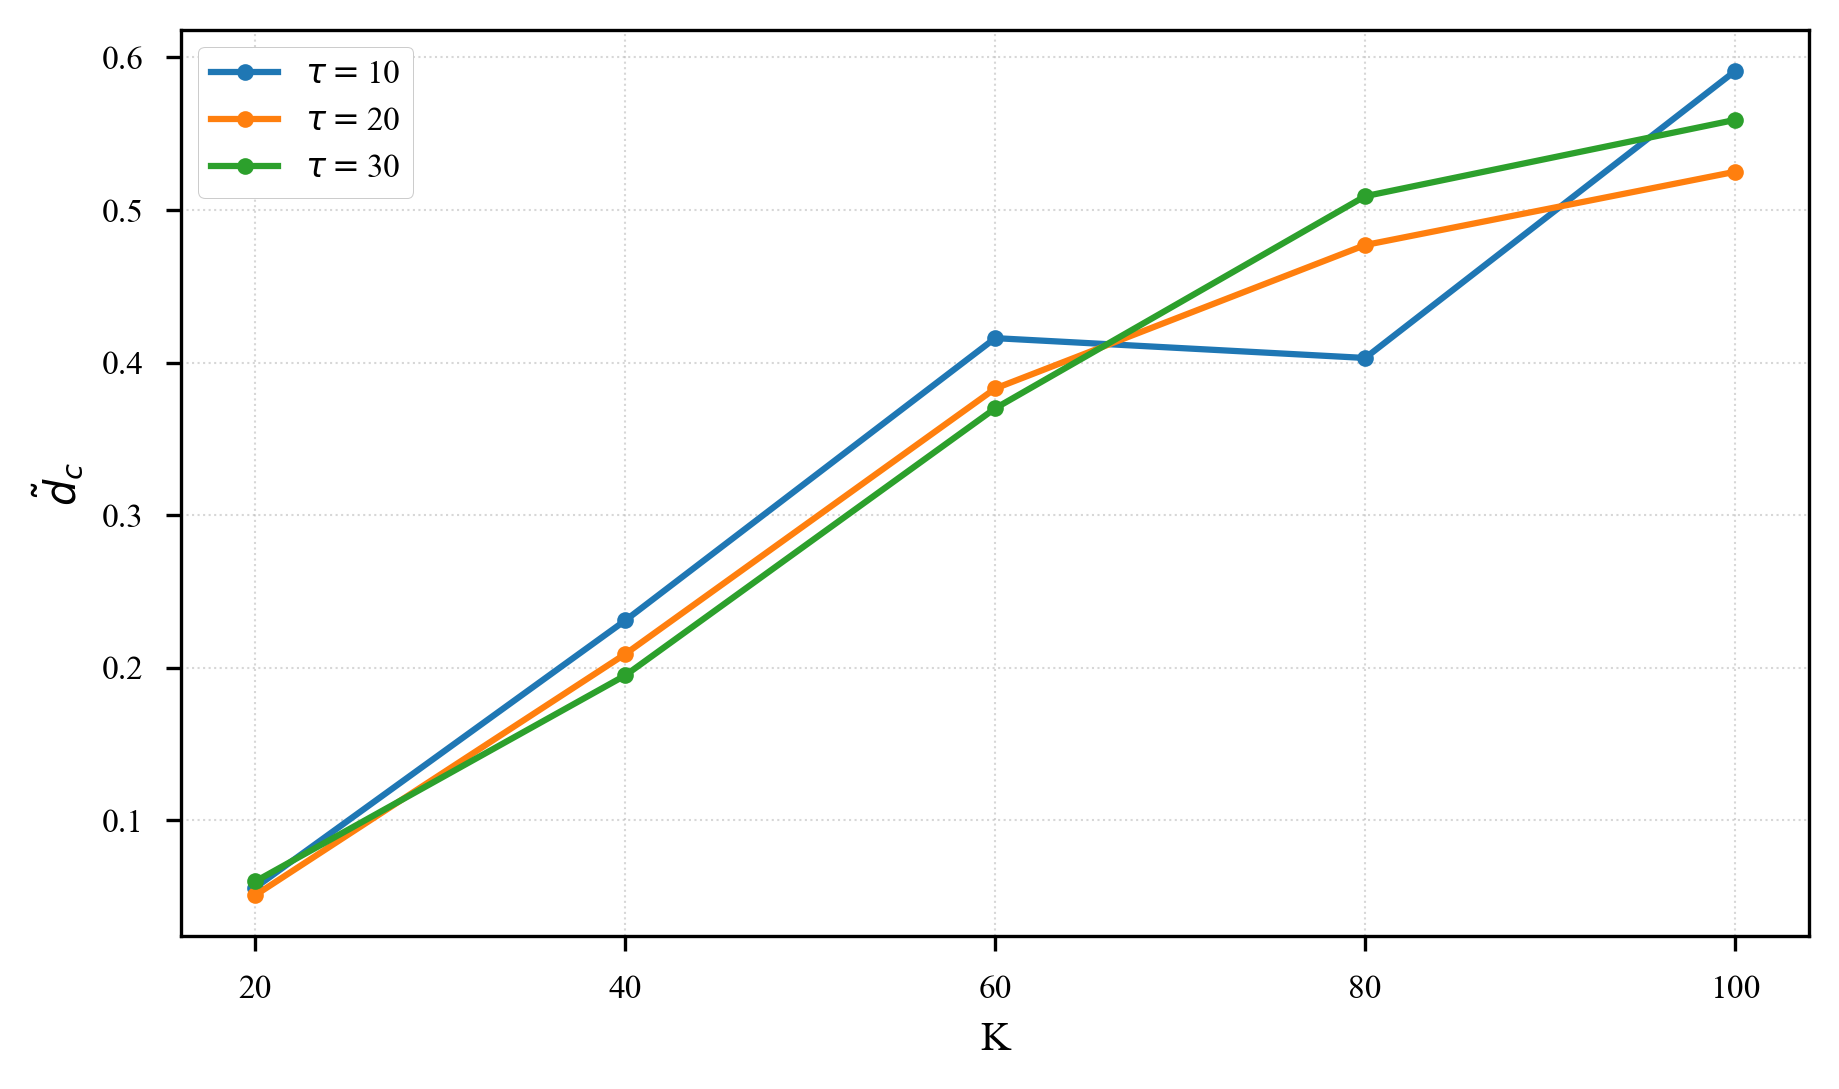

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# ======================
# NEURIPS STYLE SETTINGS
# ======================
plt.style.use('seaborn-v0_8-paper')  # Changed from 'seaborn-paper' to valid style
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 5
rcParams['axes.labelsize'] = 5
rcParams['axes.titlesize'] = 7
rcParams['legend.fontsize'] = 5
rcParams['xtick.labelsize'] = 3
rcParams['ytick.labelsize'] = 3
rcParams['figure.dpi'] = 300
rcParams['savefig.dpi'] = 300
rcParams['axes.grid'] = True
rcParams['grid.alpha'] = 0.0
rcParams['lines.linewidth'] = 2


plt.figure(figsize=(6, 3.5))  # NeurIPS prefers smaller figures

# Create plot
for i, tau_data in enumerate(results_tau):
    plt.plot(K_list, tau_data, label=r'$\tau = $' f'{tau_list[i]}', 
             marker='o', markersize=4, linewidth=1.5)

# Customize the plot
plt.xlabel('K', fontsize=10)
plt.ylabel(r'$\tilde{d}_c$', fontsize=10)
plt.grid(True, linestyle=':', alpha=0.5, linewidth=0.5)
plt.legend(fontsize=8, framealpha=1, frameon=True)

# Use tight layout and adjust ticks
plt.xticks(K_list, fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout(pad=0.5)

 #Save with appropriate DPI for publications
plt.savefig(f'berry-esseen_client_error_variance_{varscale}_K_varying, tau={tau}, eta={eta}, alpha ={alpha},N={T}, K_list={K_list}, tau={tau_list}.png', 
            bbox_inches='tight', 
            pad_inches=0.05,
            dpi=300)